## Section 2. Data Understanding
### 2.1 Dataset Information

In [43]:
import os
import warnings
from pathlib import Path

# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Suppress all warnings
warnings.filterwarnings("ignore")

# Set pandas display options for better visibility
pd.set_option("display.max_columns", None)

# Set Seaborn theme for better aesthetics
sns.set_theme()


data_path = Path("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv")

if data_path.exists():
    real_df = pd.read_csv(data_path)
    df = real_df.copy()
    print(df.info())
    display(df.head())
else:
    print(f"File not found: {data_path}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Komposisi dataset berbeda, di mana luasnya naik. Sebelumnya sekitar 4900 baris dan 11 kolom, sekarang 7043 baris dan 21 kolom.

Ntar copas dari kaggle aja.

### 2.2 Missing Values Checking

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


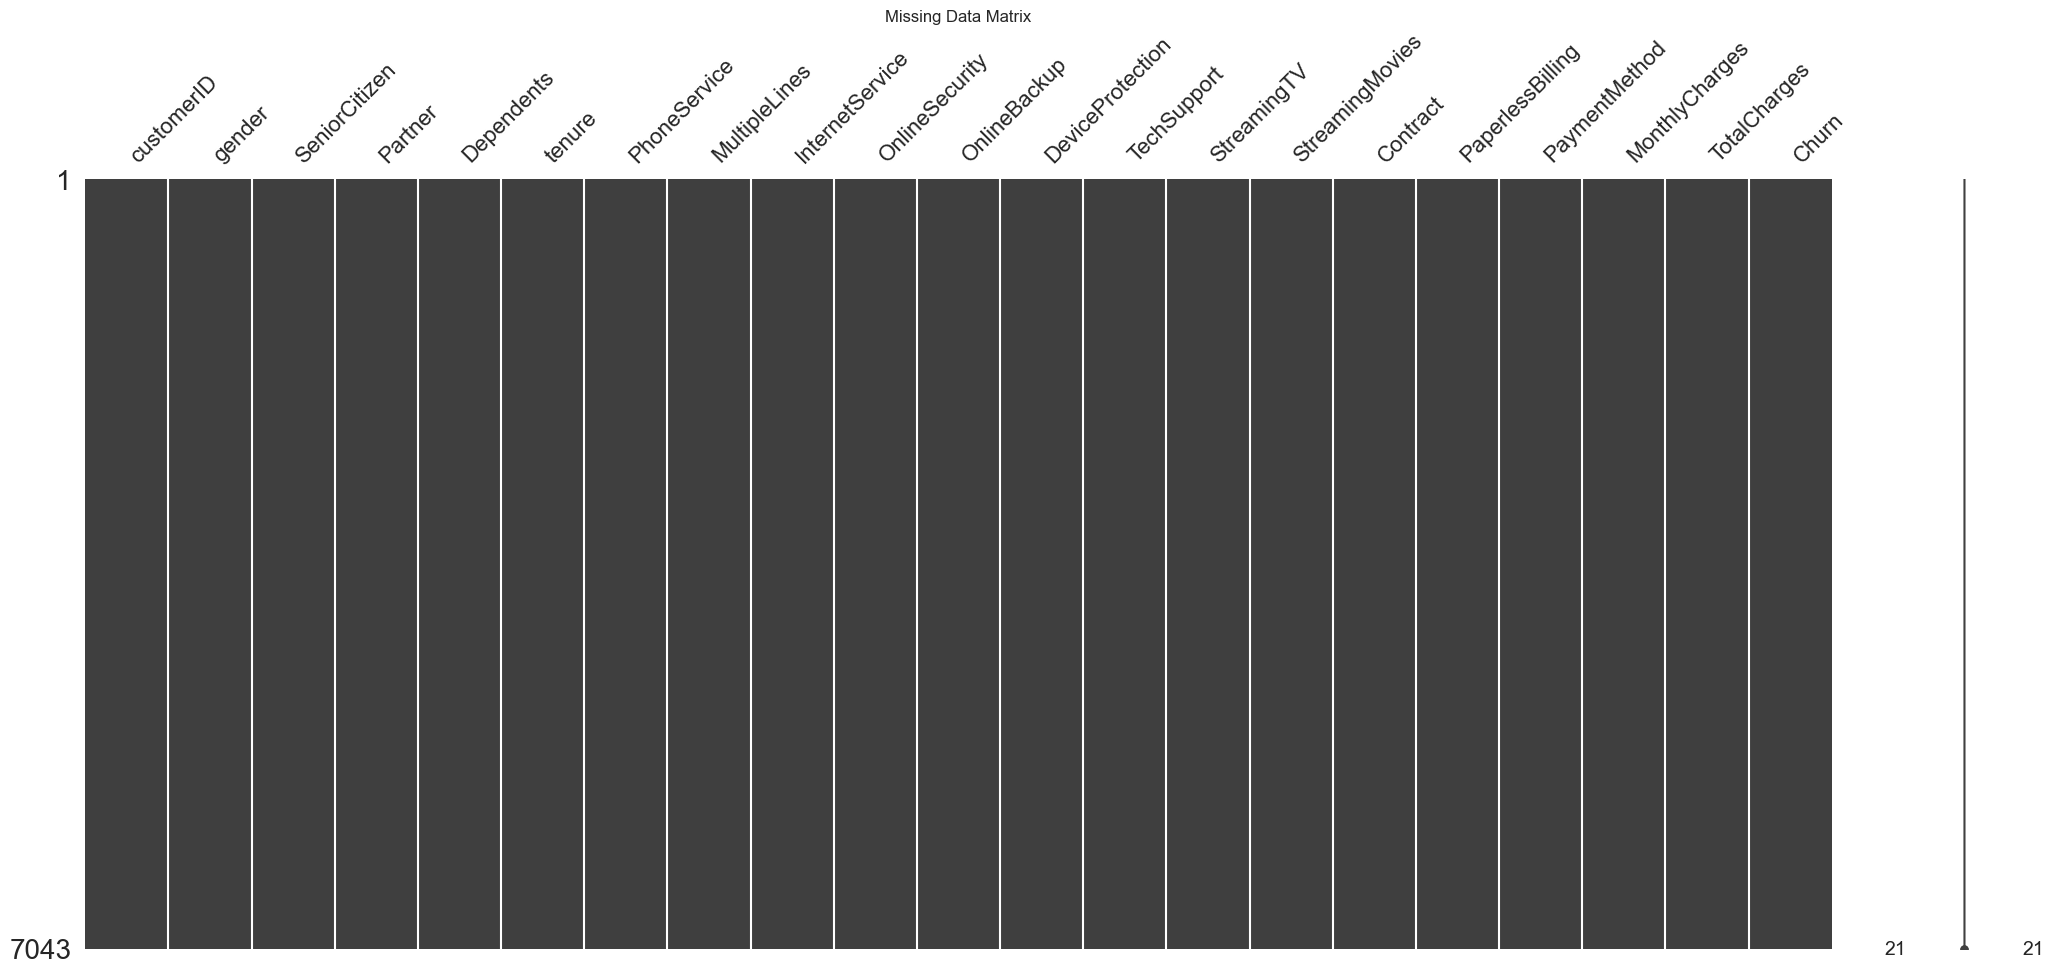

In [44]:
# Check missing values count per column
missing_counts = df.isnull().sum()
print(missing_counts)

# Visualize missing data pattern
msno.matrix(df)
plt.title('Missing Data Matrix')
plt.show()

Meskipun tidak terdapat missing values secara eksplisit dalam dataset, keberadaan nilai `tenure = 0` perlu diperhatikan karena dapat merepresentasikan pelanggan yang baru mendaftar dan belum benar-benar aktif, atau langsung churn pada bulan pertama. Hal ini penting karena bisa mempengaruhi kualitas data dan performa model machine learning, terutama jika jumlahnya kecil namun berdampak besar dalam proses pembelajaran model. Dari sisi bisnis, pelanggan dengan `tenure = 0` mungkin belum sempat menggunakan layanan secara penuh, sehingga berpotensi mencerminkan signup palsu atau pembatalan instan. Oleh karena itu, baris dengan nilai ini sebaiknya dianalisis lebih lanjut, dipertimbangkan untuk dipisahkan, atau bahkan dibuang jika tidak relevan.

In [45]:
df[df['tenure']==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Dari tabel yang ditampilkan, terlihat bahwa seluruh baris dengan `tenure = 0` memiliki nilai `TotalCharges` yang kosong (missing). Ini memperkuat indikasi adanya **anomali data**, karena secara logika bisnis, jika seorang pelanggan sudah memiliki `MonthlyCharges` tetapi `TotalCharges` kosong, hal ini tidak konsisten. Seharusnya, meskipun pelanggan baru, `TotalCharges` minimal setara dengan `MonthlyCharges` jika telah berjalan satu bulan. Selain itu, sebagian besar pelanggan ini memiliki kontrak jangka panjang seperti "Two year", yang tidak wajar jika langsung berstatus tenure = 0 tanpa adanya tagihan. Temuan ini menunjukkan bahwa baris-baris tersebut kemungkinan merupakan data yang belum tereksekusi penuh dalam sistem atau input yang belum lengkap. Maka, penting untuk memperlakukan baris ini secara khusus—baik dengan membersihkan, memisahkan, atau mengecualikan dari pelatihan model tergantung pada tujuan analisisnya.


In [46]:
df = df[df['tenure'] != 0]
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


Terdapat anomali pada data dengan tenure = 0, di mana nilai TotalCharges tidak terisi. Hal ini wajar karena pelanggan tersebut baru bergabung sehingga belum memiliki tagihan dan status churn-nya belum dapat diketahui dengan jelas. Sesuai kesepakatan, 11 baris dengan tenure = 0 dihapus dari dataset karena dianggap tidak merepresentasikan perilaku pelanggan aktif. Data ini hanya mencakup sekitar 0.15% dari total, sehingga dampaknya terhadap analisis sangat kecil. Keputusan ini juga didukung oleh literatur, di mana menurut Schafer (1999) dan Bennett (2001), data yang hilang kurang dari 5% umumnya tidak menyebabkan bias signifikan jika dihapus secara langsung. Oleh karena itu, penghapusan dilakukan untuk keperluan EDA maupun pelatihan model machine learning. 

(Namun, sebaiknya tetap dikonfirmasi terlebih dahulu kepada Mas Andi untuk validasi akhir.)

### 2.3 Duplicated Values Checking

In [47]:
# Count duplicated rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicated rows: {num_duplicates}")

Number of duplicated rows: 0


Hasil pemeriksaan duplikasi dengan fungsi `df.duplicated().sum()` menunjukkan bahwa tidak terdapat baris yang sama persis (duplikat) dalam dataset, yaitu sejumlah 0 baris duplikat. Hal ini menandakan bahwa setiap entri dalam data bersifat unik setelah penghapusan baris dengan `tenure = 0`, sehingga tidak diperlukan tindakan lebih lanjut terkait duplikasi. Keberadaan data yang bebas duplikasi sangat penting untuk menjaga kualitas analisis dan mencegah bias yang dapat muncul pada tahap pelatihan model machine learning.

### 2.4 Dataset Restructuring for Better EDA

In [48]:
# Convert object columns to category dtype
object_cols = df.select_dtypes(include=['object']).columns.tolist()
object_cols = [col for col in object_cols if col not in ('customerID', 'TotalCharges')]
df[object_cols] = df[object_cols].astype('category')
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'}).astype('category')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Confirm changes
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7032 non-null   object  
 1   gender            7032 non-null   category
 2   SeniorCitizen     7032 non-null   category
 3   Partner           7032 non-null   category
 4   Dependents        7032 non-null   category
 5   tenure            7032 non-null   int64   
 6   PhoneService      7032 non-null   category
 7   MultipleLines     7032 non-null   category
 8   InternetService   7032 non-null   category
 9   OnlineSecurity    7032 non-null   category
 10  OnlineBackup      7032 non-null   category
 11  DeviceProtection  7032 non-null   category
 12  TechSupport       7032 non-null   category
 13  StreamingTV       7032 non-null   category
 14  StreamingMovies   7032 non-null   category
 15  Contract          7032 non-null   category
 16  PaperlessBilling  7032 non-nu

Untuk menyederhanakan analisis dan mengoptimalkan penggunaan memori, seluruh kolom bertipe `object`—kecuali `customerID` dan `TotalCharges`—diubah menjadi tipe data `category`, karena kolom-kolom ini merepresentasikan data kategorikal. Selain itu, kolom `SeniorCitizen`, yang semula berupa numerik biner (0 dan 1), dipetakan menjadi kategori `"No"` dan `"Yes"` untuk meningkatkan interpretabilitas. Kolom `TotalCharges` juga dikonversi ke tipe numerik (`float64`) dengan `errors='coerce'` untuk memastikan konsistensi data. Setelah transformasi, dataset terdiri dari 21 kolom dengan 17 kolom bertipe kategori, 2 numerik kontinu (`MonthlyCharges`, `TotalCharges`), 1 numerik diskrit (`tenure`), dan 1 kolom identitas (`customerID`). Transformasi ini berhasil memperbaiki struktur data untuk keperluan analisis eksploratif dan pemodelan lebih lanjut.

### 2.5 Univariate Exploratory Data Analysis (EDA)

#### 2.5.1 Statistics Summary

In [49]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


Statistik deskriptif dari tiga kolom numerik—`tenure`, `MonthlyCharges`, dan `TotalCharges`—memberikan gambaran penting mengenai karakteristik pelanggan. Rata-rata lama berlangganan (`tenure`) adalah sekitar 32 bulan, dengan sebaran yang cukup lebar (standar deviasi 24,5), dan rentang waktu antara 1 hingga 72 bulan, menunjukkan variasi yang besar dalam loyalitas pelanggan. Biaya bulanan (`MonthlyCharges`) memiliki nilai rata-rata sekitar \$64,80, dengan mayoritas pelanggan membayar antara \$35,59 (kuartil bawah) hingga \$89,86 (kuartil atas), menandakan adanya segmen pelanggan dengan tingkat pengeluaran berbeda. Untuk total biaya keseluruhan (`TotalCharges`), rata-rata tercatat sekitar \$2.283 dengan standar deviasi \$2.267, mencerminkan perbedaan besar antara pelanggan jangka panjang dan baru. Nilai maksimum mendekati \$8.684 menunjukkan adanya pelanggan dengan masa langganan sangat panjang dan biaya kumulatif tinggi. Secara keseluruhan, data ini menunjukkan adanya keberagaman perilaku dan nilai pelanggan, yang relevan untuk strategi segmentasi dan prediksi churn.

In [50]:
df.describe(include=['object','category']).transpose()

,count,unique,top,freq
customerID,7032,7032,7590-VHVEG,1
gender,7032,2,Male,3549
SeniorCitizen,7032,2,No,5890
Partner,7032,2,No,3639
Dependents,7032,2,No,4933
PhoneService,7032,2,Yes,6352
MultipleLines,7032,3,No,3385
InternetService,7032,3,Fiber optic,3096
OnlineSecurity,7032,3,No,3497
OnlineBackup,7032,3,No,3087


Hasil statistik deskriptif untuk kolom kategorikal menunjukkan bahwa semua kolom memiliki jumlah data lengkap sebanyak 7032 entri tanpa nilai hilang. Setiap `customerID` bersifat unik, mengindikasikan tidak ada duplikasi identitas pelanggan. Mayoritas pelanggan berjenis kelamin laki-laki (3549 orang), bukan lansia (5890), tidak memiliki pasangan (3639), dan tidak memiliki tanggungan (4933). Layanan telepon digunakan oleh sebagian besar pelanggan (6352), namun banyak yang tidak menggunakan layanan tambahan seperti `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, dan `TechSupport`, dengan jawaban terbanyak adalah “No”. Layanan internet yang paling populer adalah `Fiber optic` (3096), sedangkan kontrak bulanan (`Month-to-month`) mendominasi (3875), disertai mayoritas memilih metode penagihan paperless (4168). `Electronic check` menjadi metode pembayaran paling umum (2365). Terakhir, mayoritas pelanggan dalam dataset tidak melakukan churn (5163 atau sekitar 73.4%). Data ini memberikan wawasan awal bahwa pelanggan cenderung memilih kontrak jangka pendek, tidak memanfaatkan layanan tambahan, dan menggunakan metode pembayaran elektronik—faktor-faktor yang nantinya dapat dikaji hubungannya terhadap kemungkinan churn.

#### 2.5.2 Proportion Analysis

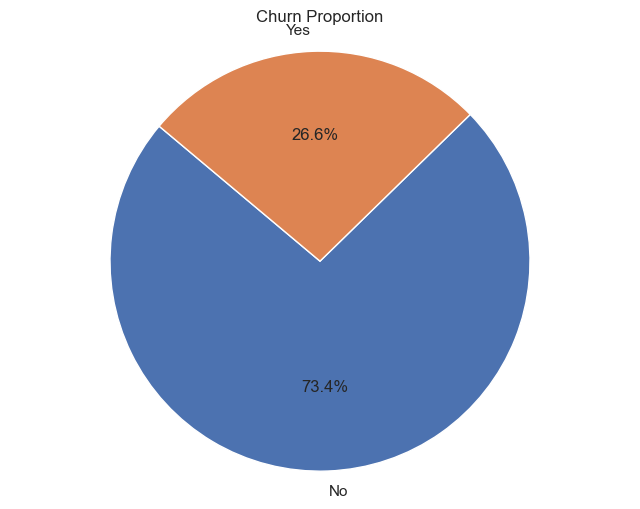

In [51]:
churn_proportion = df['Churn'].value_counts(normalize=True) * 100

plt.figure(figsize=(8, 6))
plt.pie(churn_proportion, labels=churn_proportion.index, autopct='%1.1f%%', startangle=140)
plt.title('Churn Proportion')
plt.axis('equal')  # Equal aspect ratio ensures pie chart is circular
plt.show()

Diagram pie di atas menunjukkan proporsi pelanggan yang melakukan churn dan yang tidak. Dari visualisasi tersebut, terlihat bahwa sekitar **26,6% pelanggan melakukan churn**, sementara **73,4% pelanggan tetap menggunakan layanan**. Artinya, lebih dari satu dari empat pelanggan memilih berhenti berlangganan, yang merupakan sinyal adanya potensi masalah dalam retensi pelanggan.

Secara distribusi, **dataset ini tergolong tidak seimbang (imbalanced)** karena kelas mayoritas (tidak churn) mendominasi lebih dari 70% dari total data. Menurut He & Garcia (2009), distribusi seperti ini dapat memengaruhi kinerja model prediktif karena algoritma cenderung bias terhadap kelas yang lebih dominan. Untuk mengatasi masalah ini, dapat diterapkan beberapa pendekatan seperti **resampling (oversampling/undersampling), pemberian bobot kelas (class weighting), atau pemilihan algoritma khusus yang toleran terhadap ketidakseimbangan data** agar model prediksi churn yang dihasilkan lebih akurat dan adil.


#### 2.5.3 Boxplot Analysis

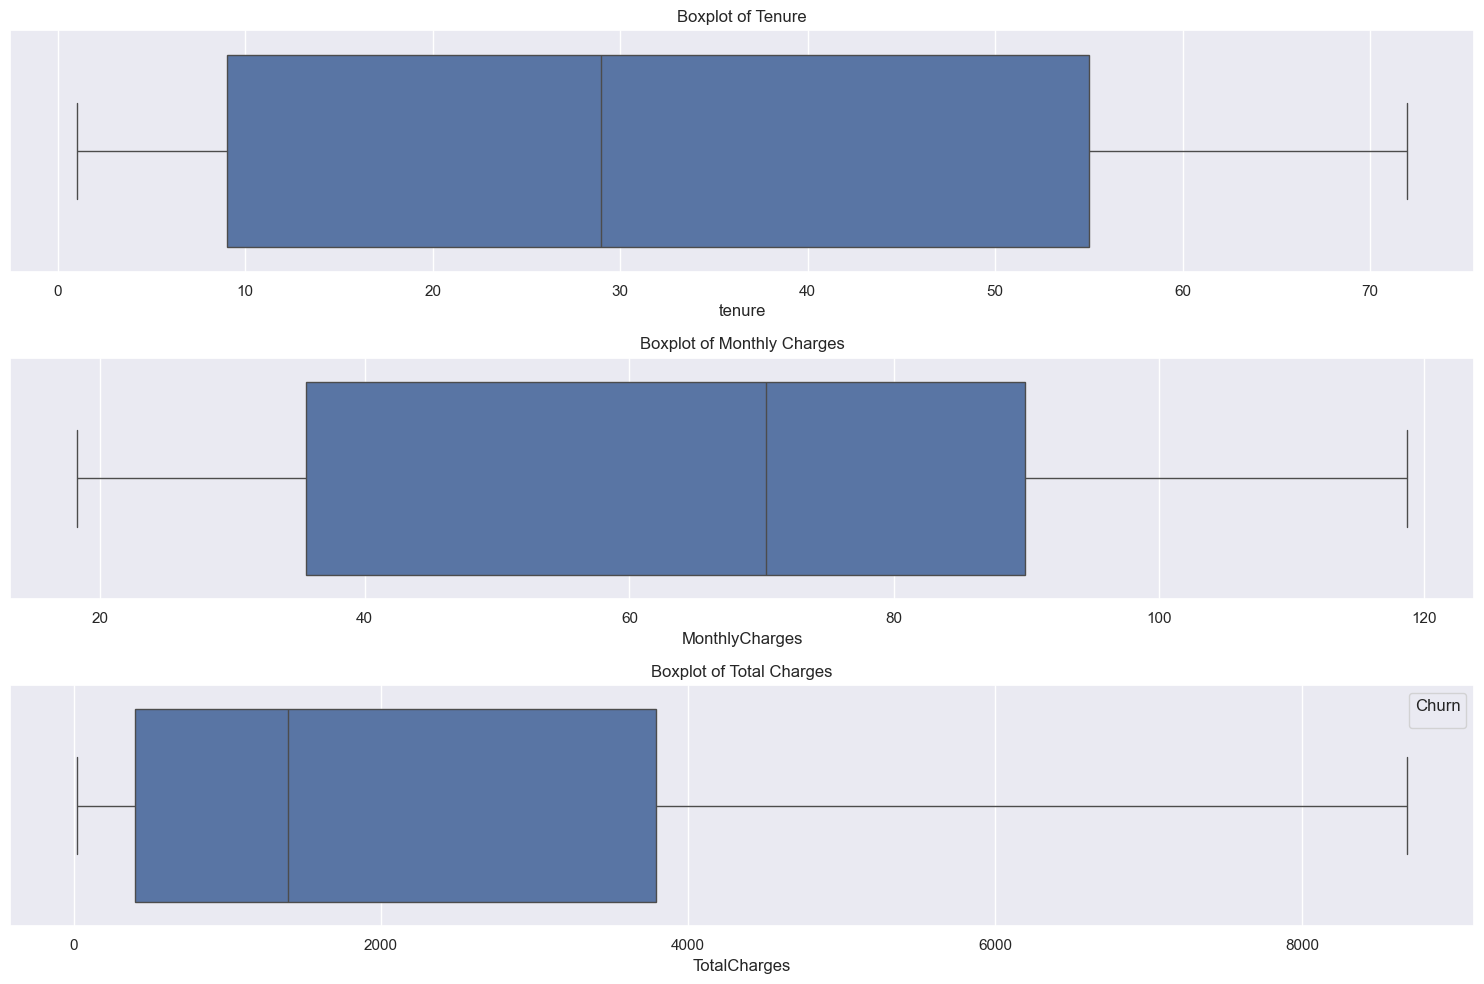

In [52]:
# Select numeric columns
numerics = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Create subplots: 3 rows, 3 columns
fig, axes = plt.subplots(3, 1, figsize=(15, 10))
axes = axes.flatten()

# 1st subplot: Boxplot of 'tenure'
sns.boxplot(x=df['tenure'], orient='h', ax=axes[0])
axes[0].set_title('Boxplot of Tenure')

# 2nd subplot: Boxplot of 'MonthlyCharges'
sns.boxplot(x=df['MonthlyCharges'], orient='h', ax=axes[1])
axes[1].set_title('Boxplot of Monthly Charges')

# 3rd subplot: KDE plot for 'tenure' by 'Churn'
sns.boxplot(x=df['TotalCharges'], orient='h', ax=axes[2])
axes[2].set_title('Boxplot of Total Charges')
axes[2].legend(title='Churn')

# Adjust layout
plt.tight_layout()
plt.show()

Hasil visualisasi boxplot menunjukkan bahwa sebagian besar pelanggan memiliki masa berlangganan (tenure) di bawah 50 bulan, dengan median sekitar 30 bulan. Pelanggan yang churn umumnya memiliki tenure yang lebih pendek, menunjukkan bahwa pelanggan cenderung berhenti pada awal masa berlangganan. Untuk biaya bulanan (monthly charges), median berada di sekitar \$70, dan sebagian besar pelanggan membayar antara \$60 hingga \$100 per bulan. Biaya bulanan yang tinggi dapat berkontribusi pada risiko churn jika tidak sebanding dengan manfaat yang dirasakan pelanggan. Sementara itu, total biaya yang dikeluarkan pelanggan selama berlangganan (total charges) sebagian besar berada di bawah \$4000, dengan pelanggan churn cenderung memiliki total charges yang rendah. Hal ini mengindikasikan bahwa churn lebih sering terjadi pada pelanggan baru atau yang belum lama menggunakan layanan. Secara keseluruhan, pelanggan dengan masa pakai pendek, biaya bulanan tinggi, dan total pengeluaran rendah merupakan kelompok yang paling berisiko melakukan churn.

#### 2.5.4 Unique Values Analysis

In [ ]:
cat_cols = df.select_dtypes(include=['category']).columns

# Dictionary of unique counts per categorical column
unique_counts = {col: df[col].nunique() for col in cat_cols}

# Dictionary of unique values lists per categorical column
unique_values_list = {col: df[col].unique().tolist() for col in cat_cols}

unique_summary = pd.DataFrame({'unique_counts': unique_counts, 'unique_values': unique_values_list})
unique_summary

,unique_counts,unique_values
gender,2,"[Female, Male]"
SeniorCitizen,2,"[No, Yes]"
Partner,2,"[Yes, No]"
Dependents,2,"[No, Yes]"
PhoneService,2,"[No, Yes]"
MultipleLines,3,"[No phone service, No, Yes]"
InternetService,3,"[DSL, Fiber optic, No]"
OnlineSecurity,3,"[No, Yes, No internet service]"
OnlineBackup,3,"[Yes, No, No internet service]"
DeviceProtection,3,"[No, Yes, No internet service]"


Hasil analisis nilai unik untuk kolom kategorikal menunjukkan bahwa sebagian besar fitur memiliki jumlah kategori yang rendah, umumnya dua hingga tiga, sehingga cocok untuk analisis dan pemodelan. Misalnya, `gender`, `SeniorCitizen`, `Partner`, `Dependents`, `PhoneService`, dan `PaperlessBilling` masing-masing hanya memiliki dua kategori seperti `Yes/No` atau `Male/Female`, yang sederhana untuk interpretasi. Beberapa fitur seperti `MultipleLines`, `InternetService`, dan berbagai layanan tambahan (`OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, dll.) memiliki tiga kategori, karena mencakup opsi tambahan seperti “No \[phone/internet] service”, yang secara implisit menggambarkan ketidakterhubungan dengan layanan utama. `PaymentMethod` adalah satu-satunya fitur dengan empat kategori, mencerminkan variasi preferensi pembayaran pelanggan. Temuan ini menegaskan bahwa struktur kategorikal pada dataset cukup konsisten dan tidak kompleks, sehingga memudahkan dalam encoding maupun eksplorasi lebih lanjut terhadap pengaruh masing-masing fitur terhadap perilaku churn.

Dalam beberapa kolom layanan tambahan seperti `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, dan lainnya, terdapat nilai kategori `"No internet service"` yang secara teknis menunjukkan bahwa pelanggan tidak berlangganan layanan internet sama sekali. Nilai ini berbeda dari `"No"` yang berarti pelanggan memiliki internet namun memilih untuk tidak menggunakan layanan tambahan tersebut. Meskipun secara informasi `"No internet service"` valid, dari sudut pandang analisis data dan pemodelan machine learning, nilai ini sebenarnya redundant karena sudah tercermin pada kolom `InternetService = No`. Oleh karena itu, untuk menyederhanakan struktur data dan menghindari sparsity pada fitur kategorikal, nilai `"No internet service"` umumnya disamakan dengan `"No"` dalam proses praproses data sebelum pelatihan model.


### 2.6 Bivariate Exploratory Data Analysis (EDA)

#### 2.6.1 Boxplot By Churn

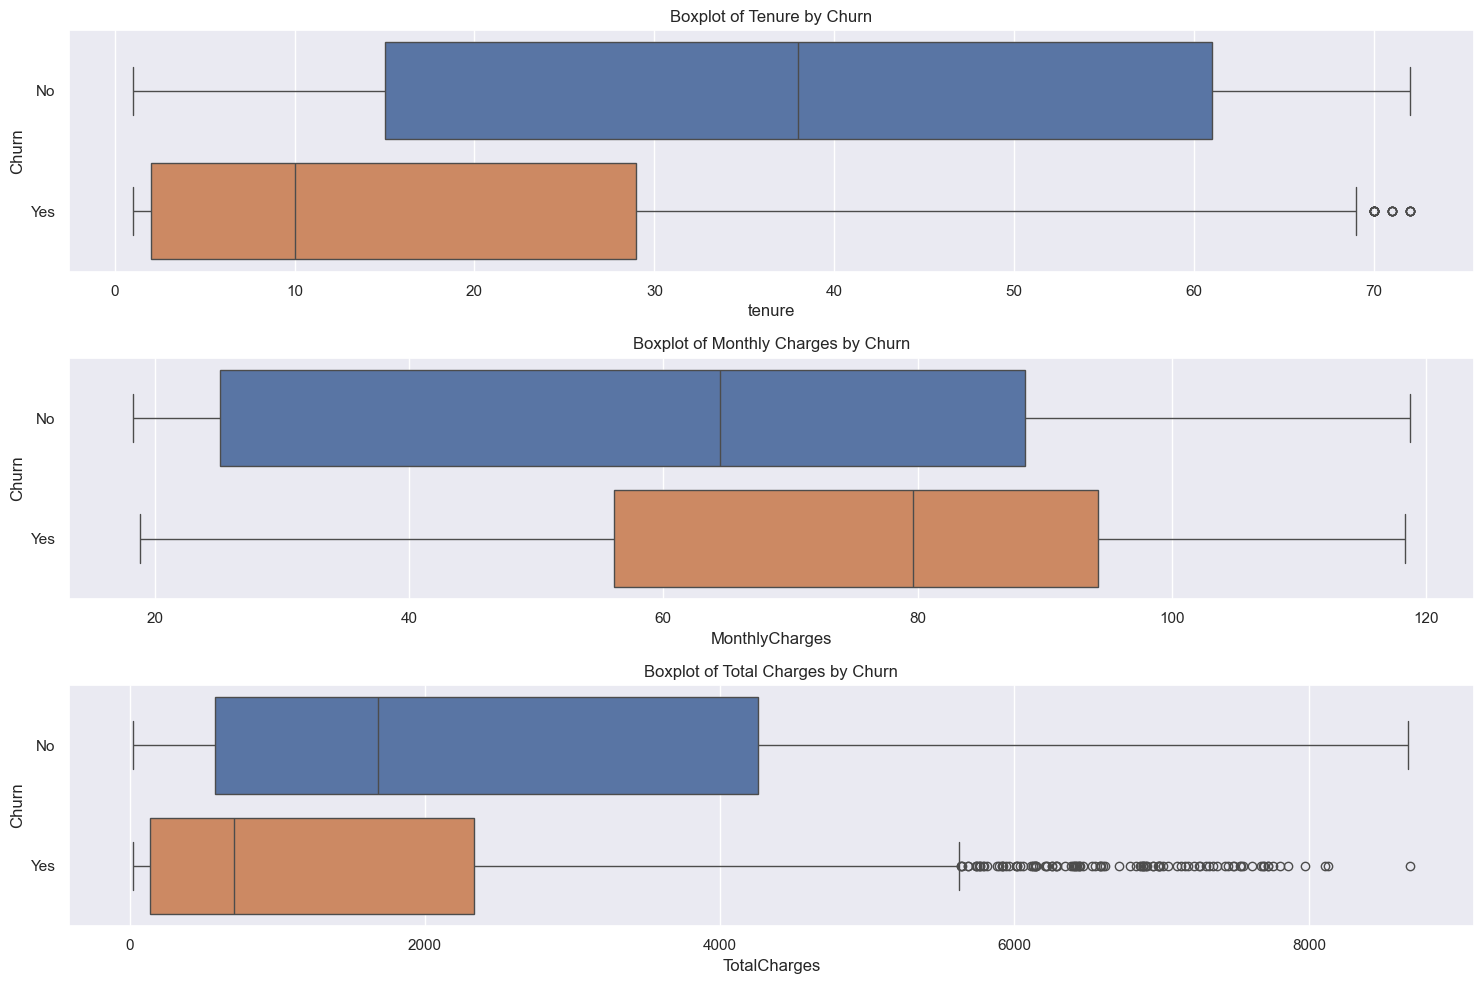

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure TotalCharges is numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Use seaborn default 'deep' palette
palette = sns.color_palette('deep')[:2]  # blue and orange
churn_categories = df['Churn'].unique()
palette_dict = dict(zip(sorted(churn_categories), palette))

# Create subplots: 3 rows, 1 column
fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Boxplot of 'tenure' by 'Churn'
sns.boxplot(x='tenure', y='Churn', data=df, orient='h', ax=axes[0], palette=palette_dict)
axes[0].set_title('Boxplot of Tenure by Churn')

# Boxplot of 'MonthlyCharges' by 'Churn'
sns.boxplot(x='MonthlyCharges', y='Churn', data=df, orient='h', ax=axes[1], palette=palette_dict)
axes[1].set_title('Boxplot of Monthly Charges by Churn')

# Boxplot of 'TotalCharges' by 'Churn'
sns.boxplot(x='TotalCharges', y='Churn', data=df, orient='h', ax=axes[2], palette=palette_dict)
axes[2].set_title('Boxplot of Total Charges by Churn')

# Adjust layout
plt.tight_layout()
plt.show()

Visualisasi boxplot menunjukkan bahwa pelanggan yang churn umumnya memiliki masa berlangganan yang lebih pendek, biaya bulanan yang lebih tinggi, dan total pengeluaran yang lebih rendah dibandingkan dengan pelanggan yang tetap bertahan. Hal ini mengindikasikan bahwa churn lebih sering terjadi pada pelanggan baru yang membayar mahal tetapi belum merasakan manfaat layanan dalam jangka panjang. Sebaliknya, pelanggan yang loyal cenderung telah berlangganan lebih lama, memiliki total pengeluaran yang tinggi, dan membayar biaya bulanan yang lebih bervariasi. Pola ini menunjukkan bahwa pelanggan baru dengan tagihan tinggi merupakan kelompok yang paling berisiko melakukan churn.

#### 2.6.2 Correlation Analysis

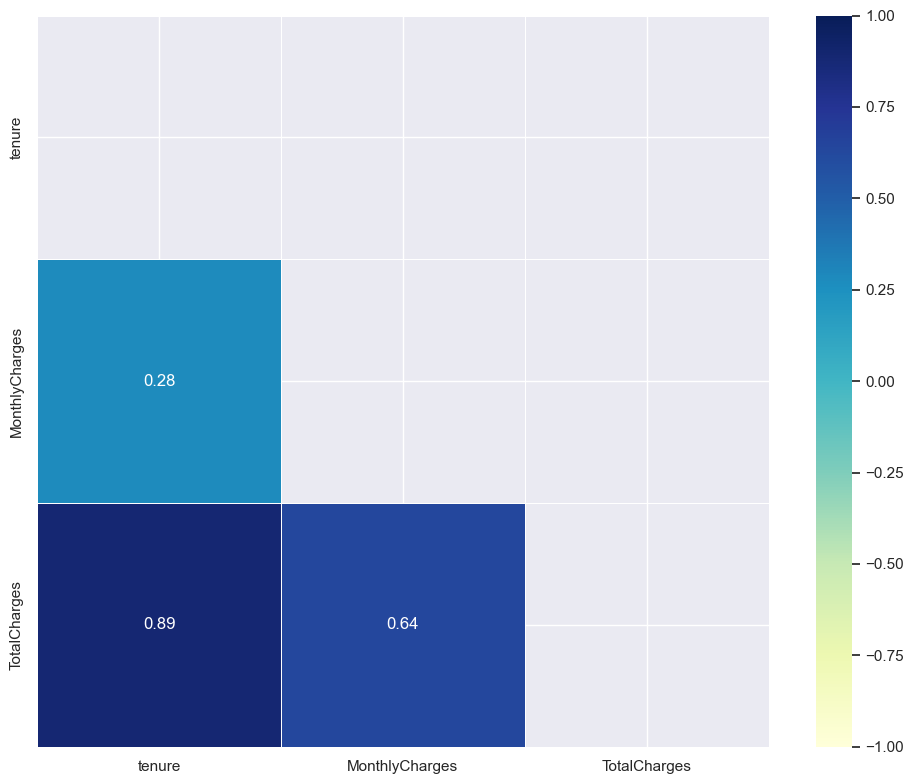

In [54]:
# Compute Spearman correlation matrix for numeric columns
corr = df.corr(numeric_only=True, method='spearman')

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(10, 8))

# 1st subplot: KDE plot for 'tenure' by 'Churn'
sns.heatmap(corr, mask=mask, annot=True, cmap='YlGnBu', vmin=-1, vmax=1, square=True, linewidths=0.5)

# Adjust layout
plt.tight_layout()
plt.show()

Heatmap korelasi Spearman menunjukkan bahwa terdapat hubungan yang kuat antara tenure dan total charges (ρ = 0,89), sedang antara monthly charges dan total charges (ρ = 0,64), serta lemah antara tenure dan monthly charges (ρ = 0,28). Artinya, semakin lama pelanggan berlangganan, total biaya yang dikeluarkan cenderung meningkat secara signifikan, sementara peningkatan biaya bulanan tidak terlalu besar. Temuan ini penting karena menunjukkan bahwa total charges merupakan hasil gabungan dari durasi berlangganan dan biaya bulanan, dan interaksi antar variabel ini dapat dimanfaatkan dalam pengembangan model prediksi churn. Interpretasi kekuatan korelasi ini mengacu pada panduan dari Schober et al. (2018), yang mengklasifikasikan nilai korelasi sebagai lemah (0,10–0,39), sedang (0,40–0,69), dan kuat (0,70–0,89).

#### 2.6.3 Pairplot Analysis

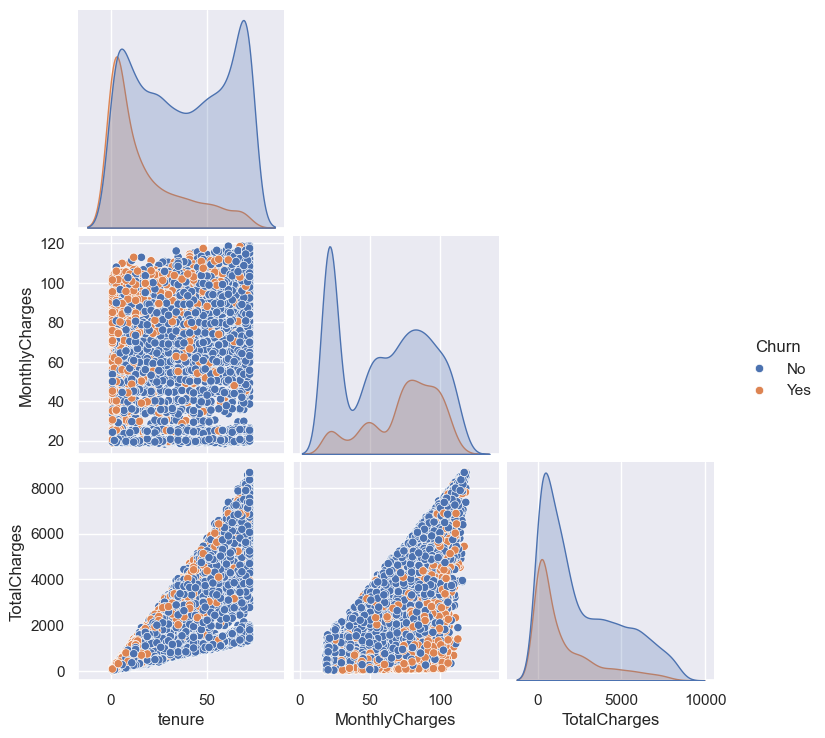

In [55]:
sns.pairplot(df, corner=True, hue='Churn');

Pairplot menunjukkan bahwa pelanggan yang churn umumnya memiliki masa berlangganan yang pendek, total pengeluaran (total charges) yang rendah, dan biaya bulanan (monthly charges) yang relatif tinggi. Distribusi tenure memperlihatkan bahwa pelanggan churn terkonsentrasi pada nilai rendah, sementara pelanggan yang tidak churn tersebar lebih merata. Hubungan antara tenure dan total charges tampak linier, terutama pada pelanggan yang tidak churn, sedangkan pelanggan churn umumnya berhenti sebelum total charges meningkat signifikan. Pada kombinasi monthly charges dan tenure, pelanggan churn banyak ditemukan pada kelompok dengan biaya bulanan tinggi namun masa langganan singkat. Temuan ini memperkuat bahwa pelanggan baru yang membayar mahal tetapi belum lama berlangganan memiliki risiko churn yang lebih tinggi.

#### 2.6.4 Feature Distribution Analysis (Categorical)

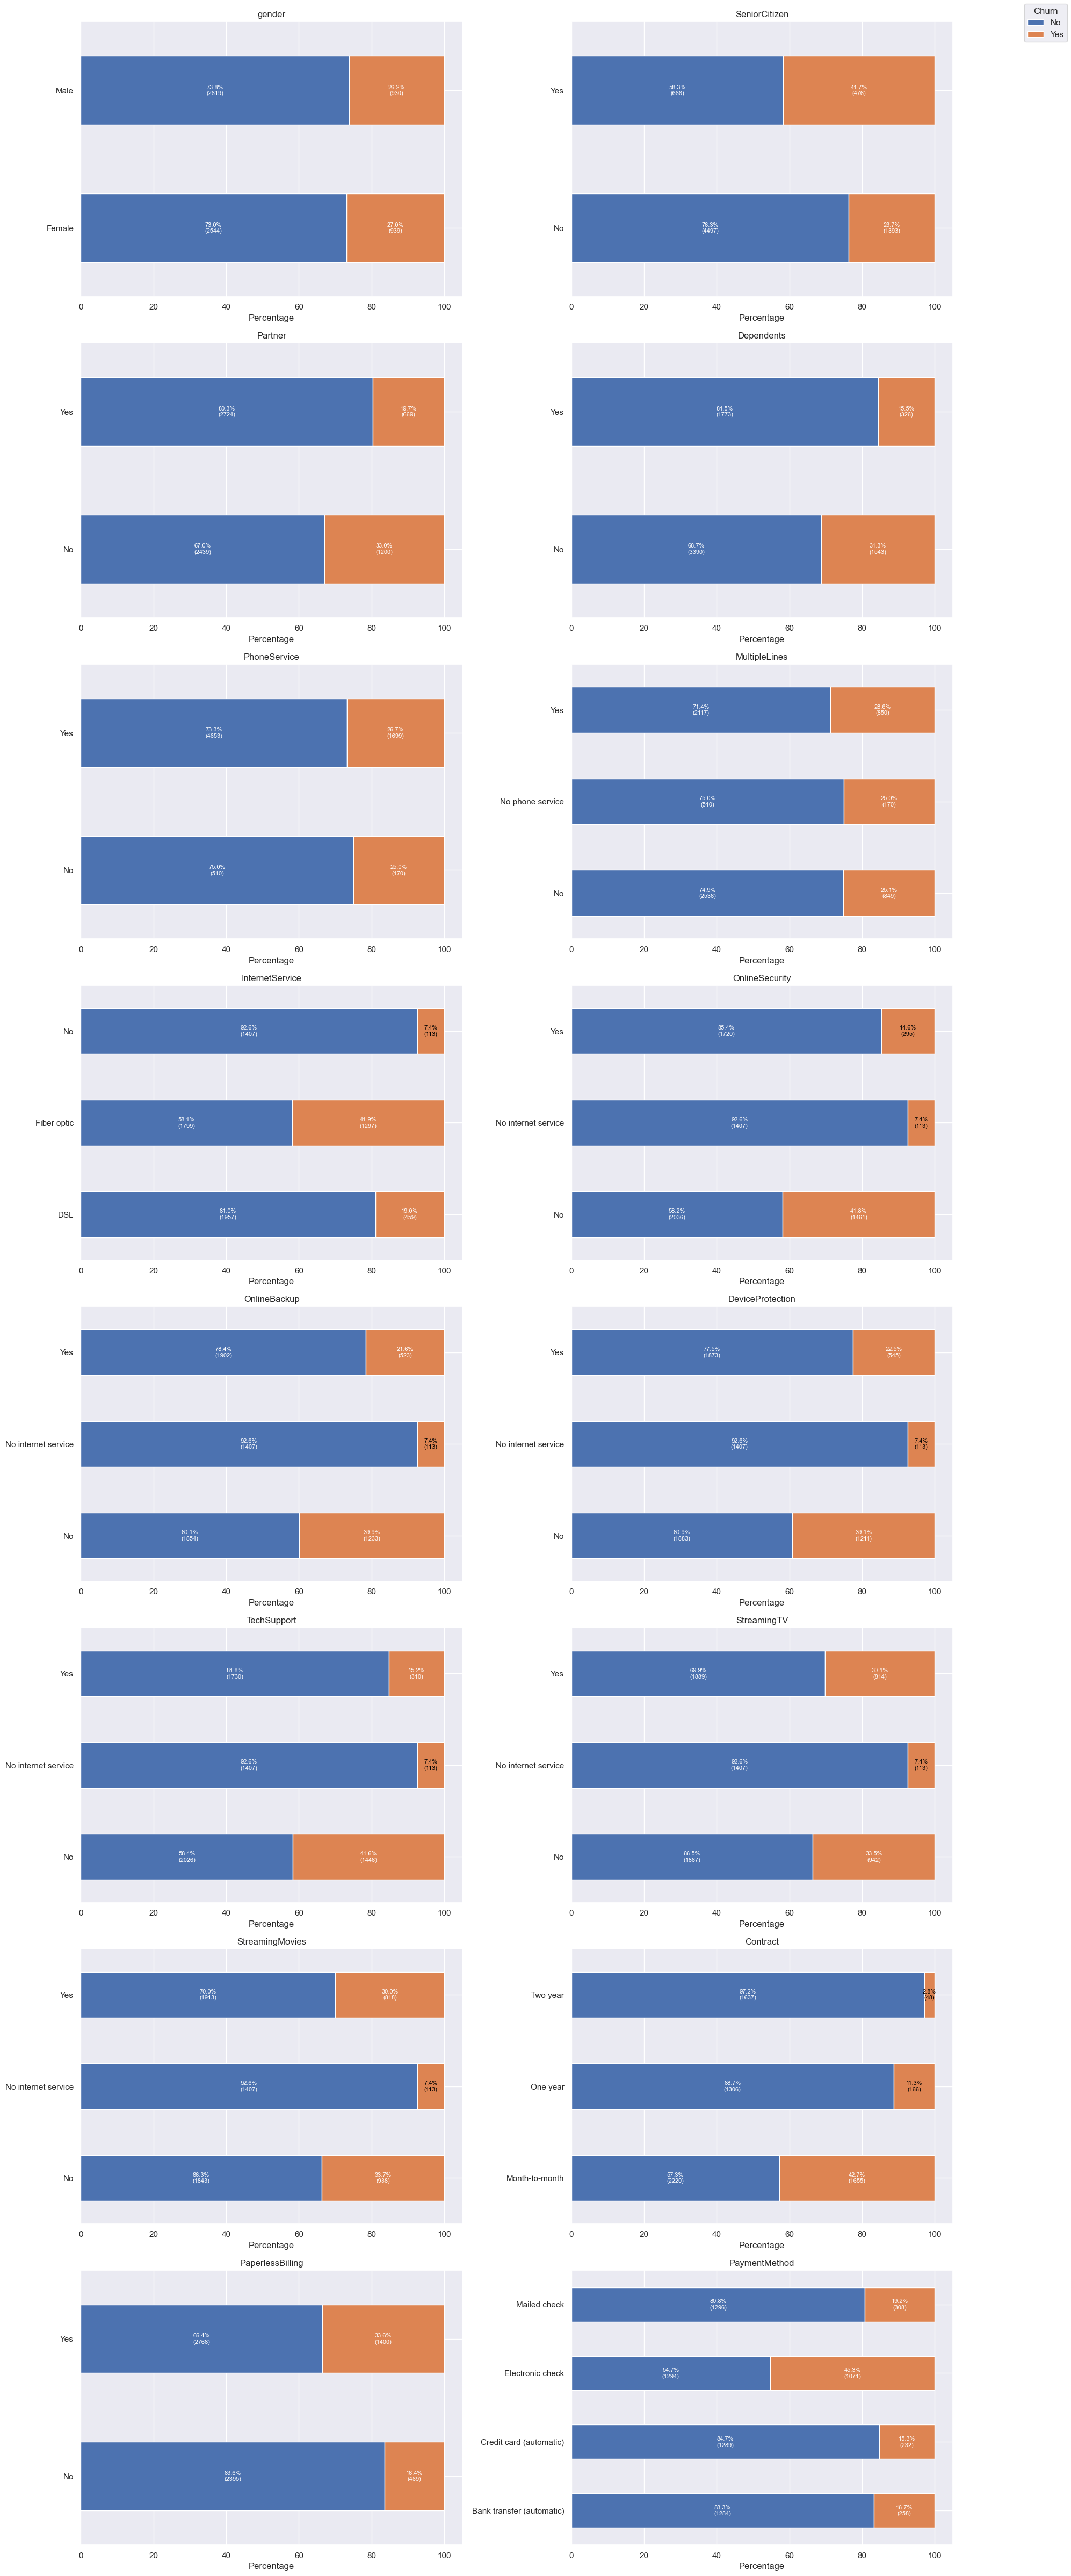

In [57]:
categorical_cols = df.select_dtypes(include='category').columns.drop('Churn')

num_plots = len(categorical_cols)
cols = 2
rows = (num_plots + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(cols * 10, rows * 6))
axes = axes.flatten()

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    
    # Compute counts per category and churn status with observed=True
    counts = df.groupby([col, 'Churn'], observed=True).size().unstack(fill_value=0)
    
    # Convert counts to percentages per category level (row-wise)
    percentages = counts.div(counts.sum(axis=1), axis=0) * 100
    
    # Plot horizontal stacked bar chart on the subplot axis
    percentages.plot(kind='barh', stacked=True, ax=ax, legend=False)
    
    ax.set_title(f'{col}')
    ax.set_xlabel('Percentage')
    ax.set_ylabel('')
    
    # Annotate each segment with percentage and count
    for j, (index, row) in enumerate(percentages.iterrows()):
        cum_width = 0
        for churn_status in percentages.columns:
            pct = row[churn_status]
            cnt = counts.loc[index, churn_status]
            if pct > 0:
                label = f'{pct:.1f}%\n({cnt})'
                ax.text(cum_width + pct / 2, j, label, ha='center', va='center', fontsize=8,
                        color='white' if pct > 15 else 'black')
                cum_width += pct

# Remove any unused subplots
for k in range(i + 1, len(axes)):
    fig.delaxes(axes[k])

# Create one legend for all plots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, title='Churn', loc='upper right')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space on right for legend
plt.show()

...

## 2.6 Save Dataset

In [60]:
df.to_csv('../data/telco_data_eda.csv', index=False)